- Use RNNs used for images

#### Architecture

- Let's pretend image is a sequence of word vectors (T * D Matrix)
- Pretend height = T, width = D
- Run BiLSTM 

Then Rotate the image 90 degree and run BiLSTM again, we get two model
- Global max pooling
- Concatenate
- Dense


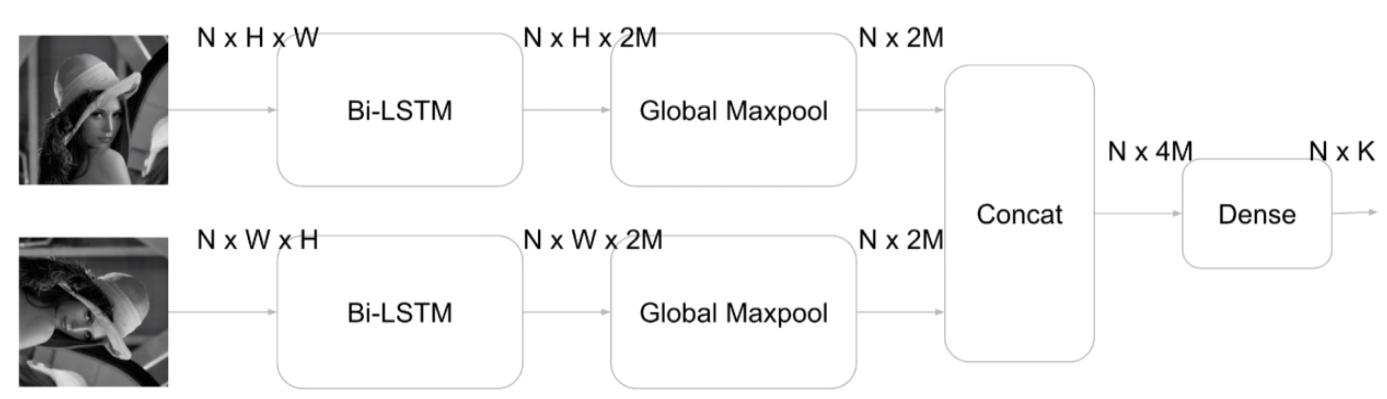

In [11]:
# https://deeplearningcourses.com/c/deep-learning-advanced-nlp
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

import os
from keras.models import Model
from keras.layers import Input,LSTM,GRU,Bidirectional, GlobalMaxPooling1D,Lambda, Concatenate,Dense
import keras.backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



#### Download MNIST 

In [12]:
def get_mnist(limit=None):
    if not os.path.exists('large_files'):
        print("You must create a folder called large_files adjacent to the class folder first.")
    if not os.path.exists('large_files/MNIST/train.csv'):
        print("Looks like you haven't downloaded the data or it's not in the right spot.")
        print("Please get train.csv from https://www.kaggle.com/c/digit-recognizer")
        print("and place it in the large_files folder.")

    print("Reading in and transforming data...")
    df = pd.read_csv('large_files/MNIST/train.csv')
    data = df.values
    np.random.shuffle(data)
    X = data[:, 1:].reshape(-1, 28, 28) / 255.0 # data is from 0..255
    Y = data[:, 0]
    if limit is not None:
        X, Y = X[:limit], Y[:limit]
    return X, Y

#### Load in data and set config

In [13]:
X,Y = get_mnist()

D =28
M =15

Reading in and transforming data...


#### Build the Model

In [14]:
# input is an image of size 28x28
input_ = Input(shape = (D,D))

# up-down
rnn1 = Bidirectional(LSTM(M,return_sequences = True))
x1 = rnn1(input_)  # output is N x D x 2M
x1 = GlobalMaxPooling1D()(x1) # output is N x 2M


# left-right
rnn2 = Bidirectional(LSTM(M,return_sequences = True))

# custom layer: Rotate image by exchanging width and height
permutor = Lambda(lambda t: K.permute_dimensions(t,pattern = (0,2,1)))

x2 = permutor(input_)
x2 = rnn2(x2)   # output is N x D x 2M
x2 = GlobalMaxPooling1D()(x2)  # output is N x 2M

## Concate x1 and x2 by columns
concatenator = Concatenate(axis= 1)
x = concatenator([x1,x2])  # output is N x 4M

# final dense layer

output = Dense(10,activation = 'softmax')(x)

model = Model(inputs = input_,outputs = output)

### Compile model

## Use Spare categorical crossentropy, the target can be non one hot encoding version
model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])




In [15]:
#### Train the model
r = model.fit(X,Y,batch_size = 32,epochs = 10,validation_split = 0.3,verbose = 1)



Train on 29399 samples, validate on 12601 samples
Epoch 1/10
29399/29399 [==============================] - 273s 9ms/step - loss: 0.7515 - acc: 0.8110 - val_loss: 0.3038 - val_acc: 0.9196
Epoch 2/10
29399/29399 [==============================] - 261s 9ms/step - loss: 0.2334 - acc: 0.9379 - val_loss: 0.1844 - val_acc: 0.9472
Epoch 3/10
29399/29399 [==============================] - 265s 9ms/step - loss: 0.1660 - acc: 0.9534 - val_loss: 0.1486 - val_acc: 0.9573
Epoch 4/10
29399/29399 [==============================] - 272s 9ms/step - loss: 0.1340 - acc: 0.9613 - val_loss: 0.1381 - val_acc: 0.9582
Epoch 5/10
29399/29399 [==============================] - 268s 9ms/step - loss: 0.1143 - acc: 0.9666 - val_loss: 0.1281 - val_acc: 0.9626
Epoch 6/10
29399/29399 [==============================] - 260s 9ms/step - loss: 0.0983 - acc: 0.9709 - val_loss: 0.1061 - val_acc: 0.9678
Epoch 7/10
29399/29399 [==============================] - 257s 9ms/step - loss: 0.0855 - acc: 0.9746 - val_loss: 0.1005 - 

#### Plot the data

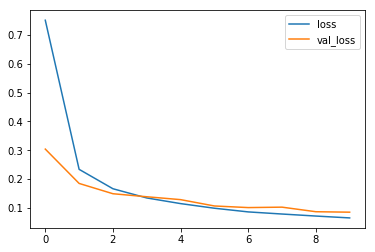

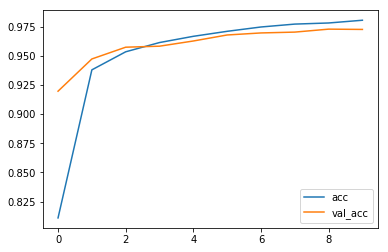

In [16]:
plt.plot(r.history['loss'],label = 'loss')
plt.plot(r.history['val_loss'],label = 'val_loss')
plt.legend()
plt.show()

plt.plot(r.history['acc'],label = 'acc')
plt.plot(r.history['val_acc'],label = 'val_acc')
plt.legend()
plt.show()